In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.7 MB/s eta 0:00:00


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [5]:
# Config
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val2-4"

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [8]:
train[f"log_cover"] = np.log1p(train["cover"])

## 特徴抽出

In [9]:
cols_sentinel = train.columns.to_list()[88:313]

In [10]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_sentinel = train.columns.to_list()[88:313]
# cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_use = cols_base + cols_sentinel + ["log_cover"]

cols_remove = ["YMD", "MAX_CVI"]
cols_use = [col for col in cols_use if not col in cols_remove]
cols_use

['lat',
 'lon',
 'area',
 'year',
 'month',
 'cover',
 'depth_original',
 'cliff_length',
 'aicial_length',
 'beach_length',
 'coast_length',
 'coastal_dist',
 'cold_sst',
 'depth',
 'fetch',
 'hist_cold_sst',
 'hist_warm_sst',
 'river_area',
 'river_dist',
 'Salinity_annual',
 'warm_sst',
 'sst_annual',
 'sst_ymd',
 'sst_diff',
 'MAX_AFRI1600',
 'MAX_AOT',
 'MAX_ARI',
 'MAX_ARVI',
 'MAX_AVI',
 'MAX_B02',
 'MAX_B03',
 'MAX_B04',
 'MAX_B05',
 'MAX_B06',
 'MAX_B07',
 'MAX_B11',
 'MAX_B12',
 'MAX_B8A',
 'MAX_BB1',
 'MAX_Bcc',
 'MAX_BGI',
 'MAX_BNDVI',
 'MAX_BOA',
 'MAX_BRI',
 'MAX_BWDRVI',
 'MAX_CARI',
 'MAX_Chlgreen',
 'MAX_Chlred_edge',
 'MAX_CI',
 'MAX_CIgreen',
 'MAX_CIrededge',
 'MAX_CLD',
 'MAX_CRred',
 'MAX_CSI',
 'MAX_D678_500',
 'MAX_Datt1',
 'MAX_Datt4',
 'MAX_DVI',
 'MAX_EVI',
 'MAX_ExG',
 'MAX_GARI',
 'MAX_GDVI',
 'MAX_GI',
 'MAX_GLI',
 'MAX_GRNDVI',
 'MAX_GVMI',
 'MAX_IF',
 'MAX_IO',
 'MAX_IPVI',
 'MAX_MCARI_MTVI2',
 'MAX_MCARI_OSAVI',
 'MAX_MCARI2',
 'MAX_MGVI',
 'MAX_MIRBI'

In [11]:
train = train[cols_use]

factors_sentinel = list(set([col[4:] for col in cols_sentinel]))
for factor in factors_sentinel:
    if factor in ["CI", "CVI"]:
        continue
    train[f"MINMAX_{factor}"] = train[f"MAX_{factor}"] - train[f"MIN_{factor}"]
    test[f"MINMAX_{factor}"] = test[f"MAX_{factor}"] - test[f"MIN_{factor}"]
    cols_use.append(f"MINMAX_{factor}")

In [12]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 321


# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [13]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(200),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [14]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
Training until validation scores don't improve for 200 rounds
[500]	valid_0's fair: 0.0030848
Early stopping, best iteration is:
[418]	valid_0's fair: 0.00308245


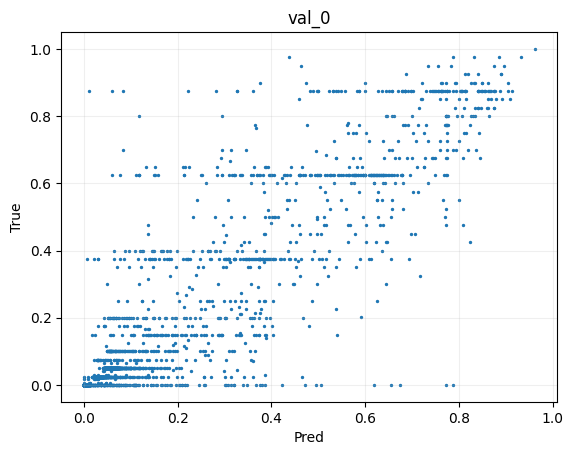

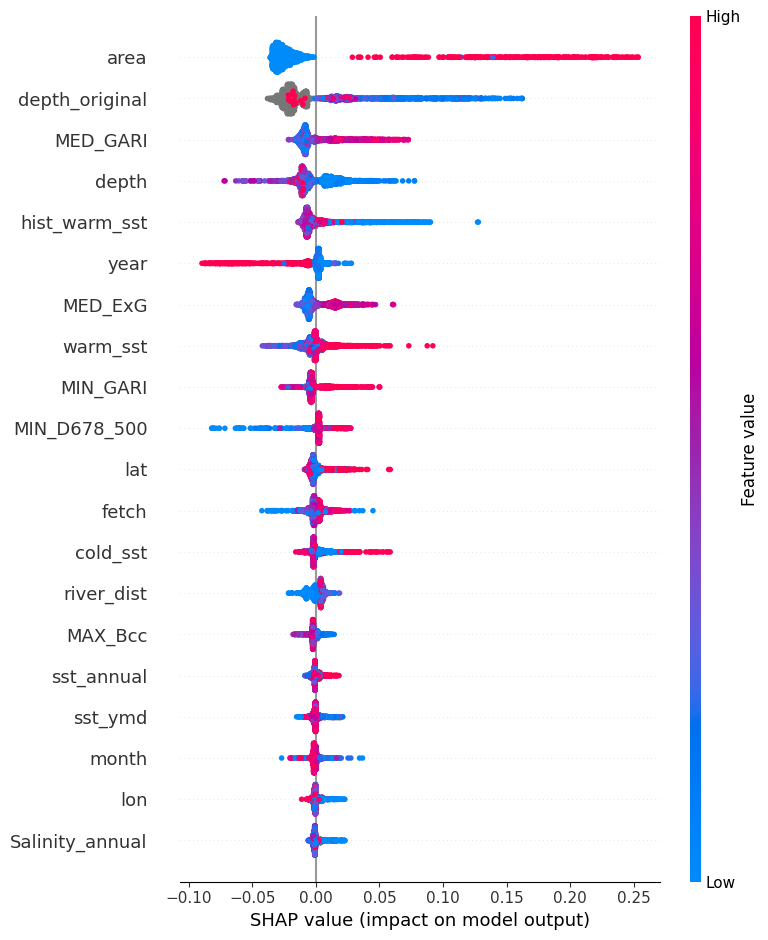

##############################
● CV1
##############################
Training until validation scores don't improve for 200 rounds
[500]	valid_0's fair: 0.00305487
[1000]	valid_0's fair: 0.00304018
Early stopping, best iteration is:
[827]	valid_0's fair: 0.00303907


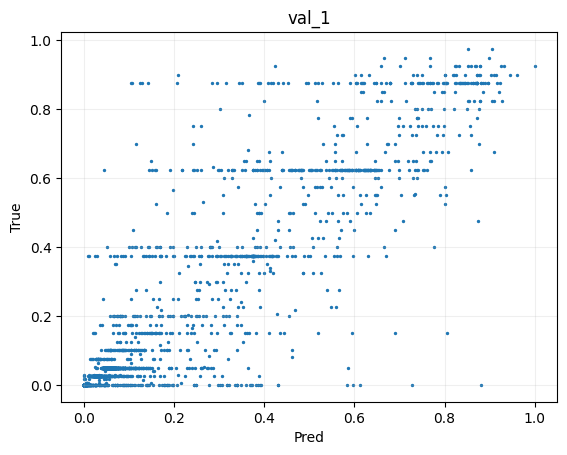

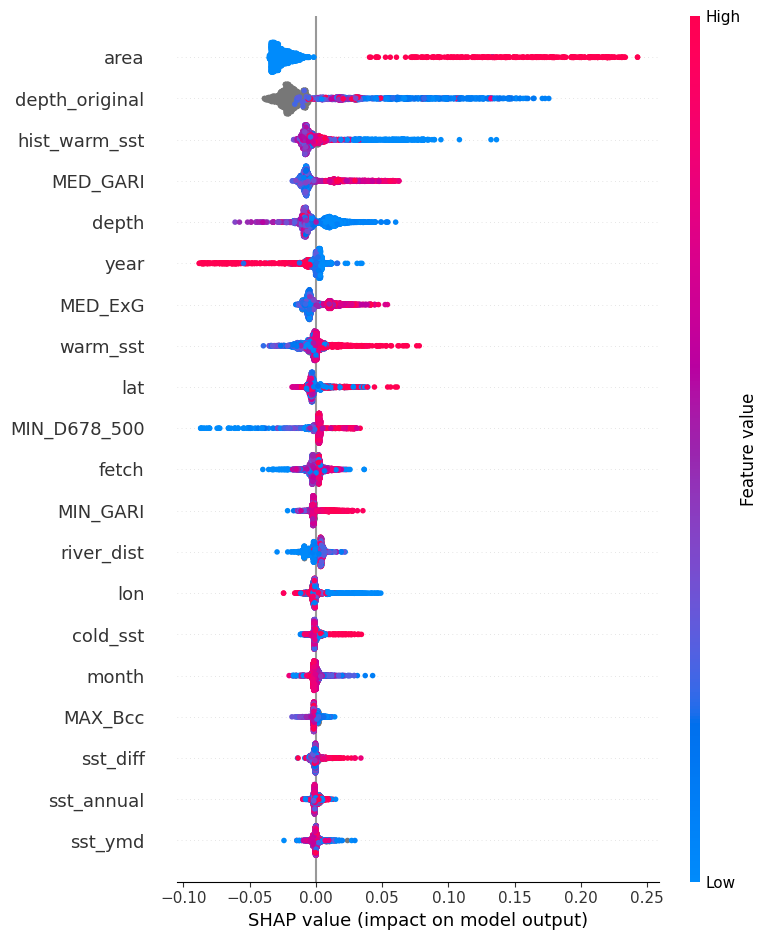

##############################
● CV2
##############################
Training until validation scores don't improve for 200 rounds
[500]	valid_0's fair: 0.00295913
Early stopping, best iteration is:
[766]	valid_0's fair: 0.00294597


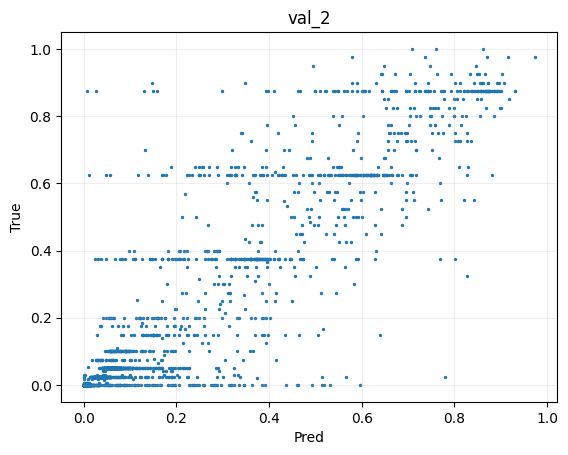

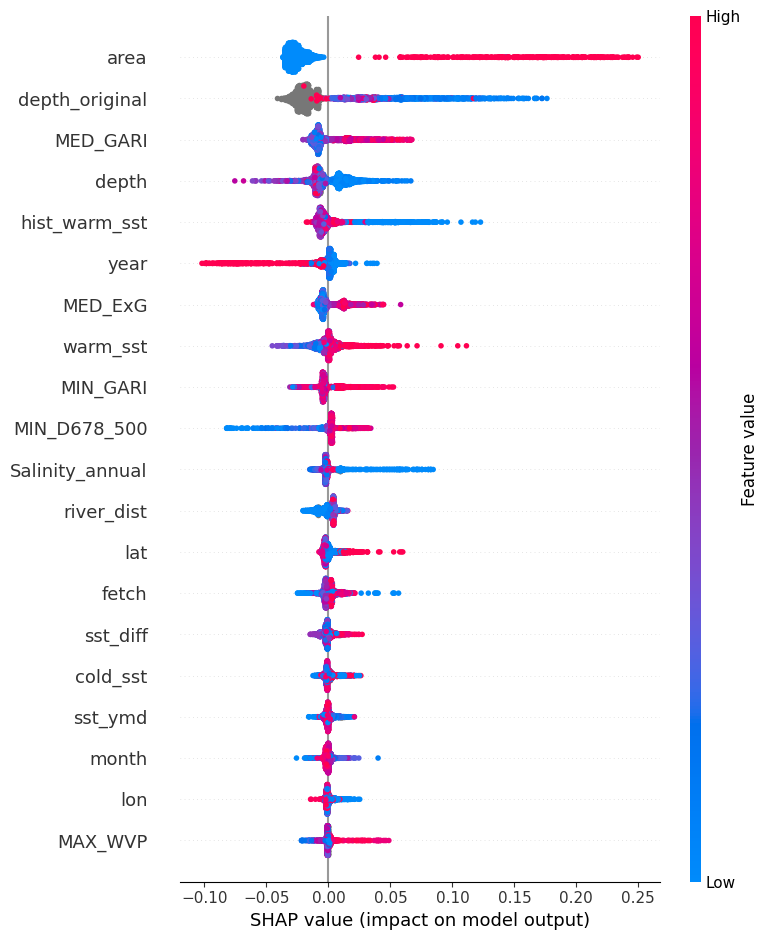

##############################
● CV3
##############################
Training until validation scores don't improve for 200 rounds
[500]	valid_0's fair: 0.00273476
[1000]	valid_0's fair: 0.00271867
Early stopping, best iteration is:
[1068]	valid_0's fair: 0.00271775


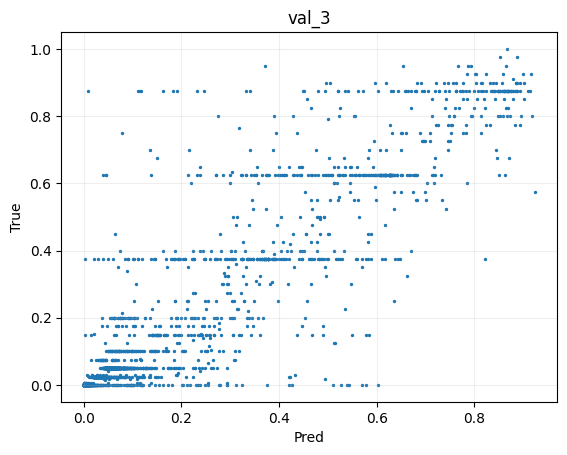

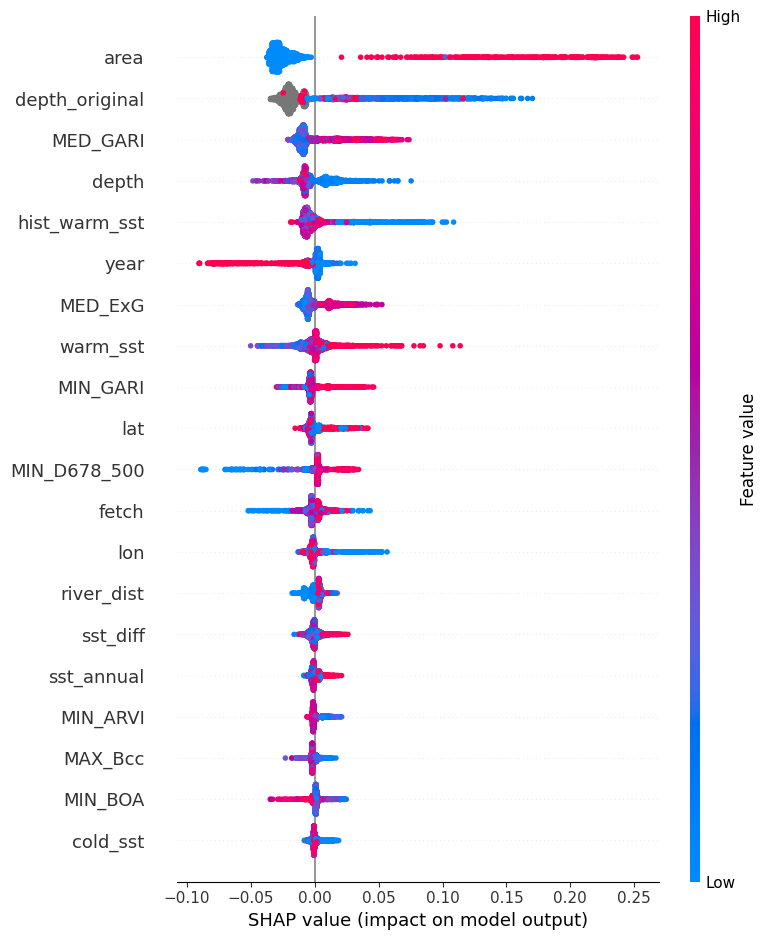

##############################
● CV4
##############################
Training until validation scores don't improve for 200 rounds
[500]	valid_0's fair: 0.00312777
[1000]	valid_0's fair: 0.00311524
Early stopping, best iteration is:
[1098]	valid_0's fair: 0.00311391


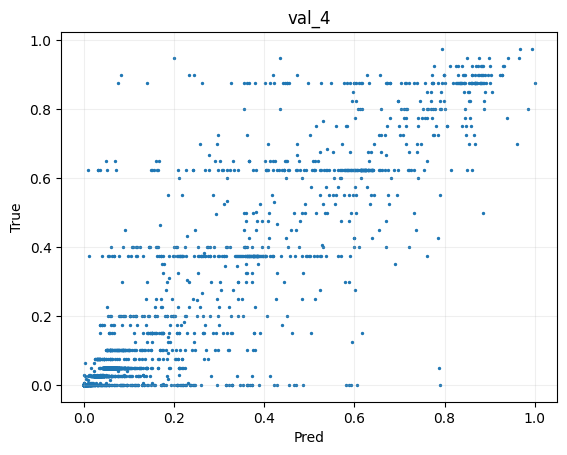

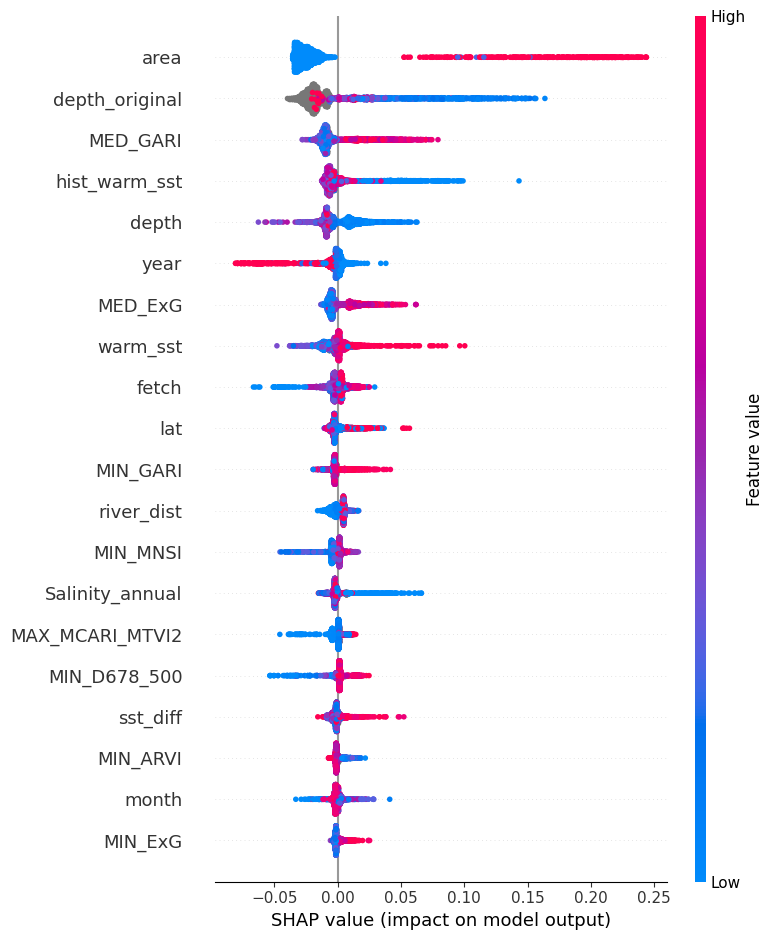

##############################
学習曲線
##############################


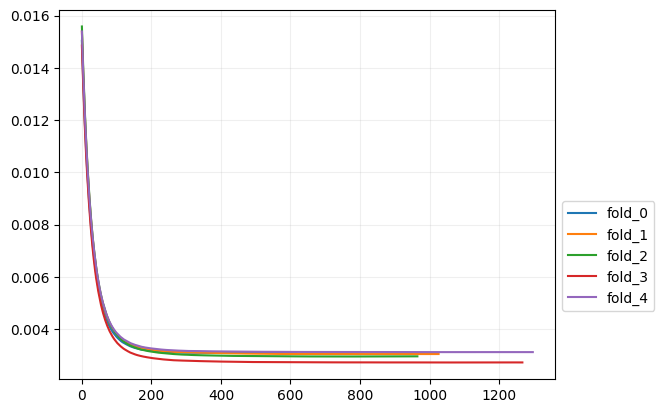

In [15]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 17, 
    'n_estimators': 4000, 
    'learning_rate': 0.017249570940885327, 
    'lambda_l1': 0.07458308290764872, 
    'num_leaves': 170, 
    'colsample_bytree': 0.6731079655436575,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover",params=params, features=features)

CV0: 0.115
CV1: 0.116
CV2: 0.113
CV3: 0.109
CV4: 0.116
Average: 0.114


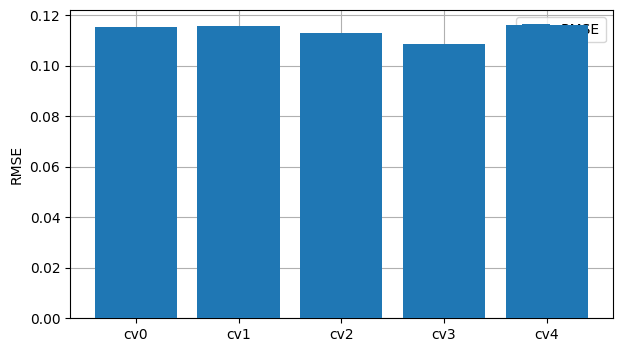

In [16]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 321)


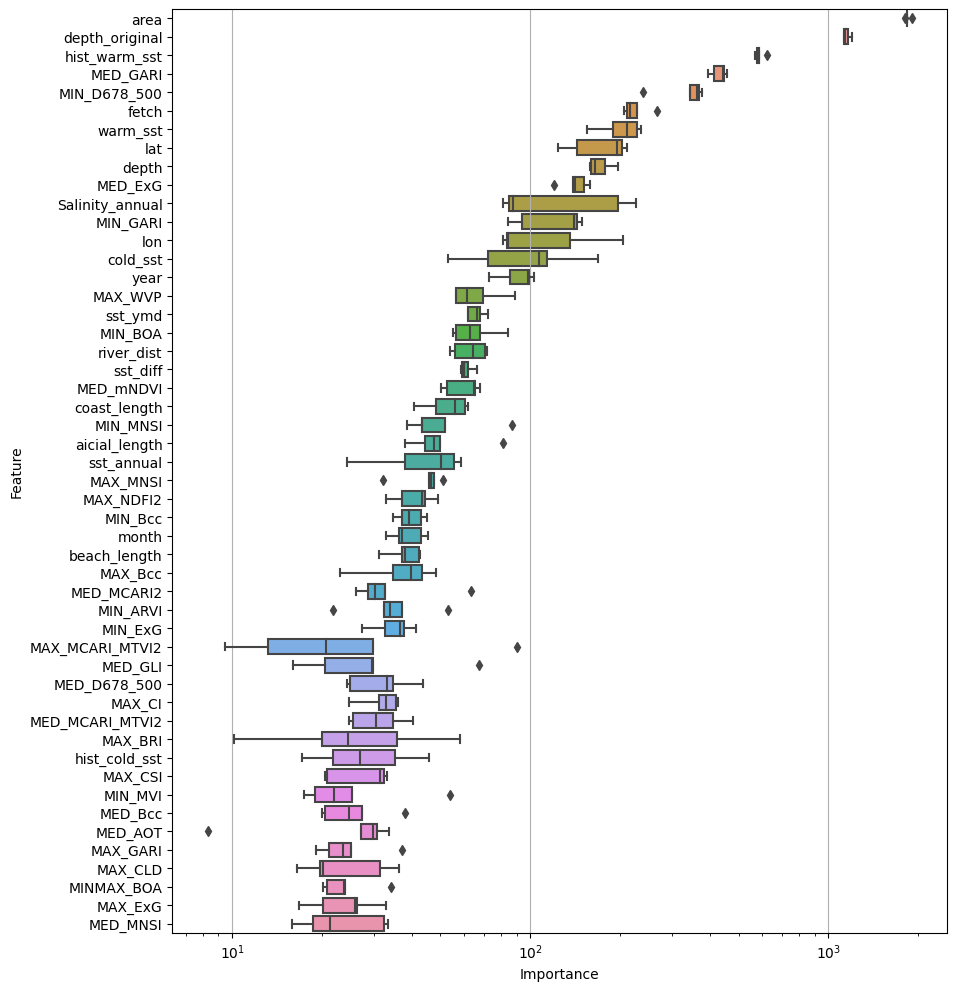

In [17]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [18]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.230832
1,0.109535
2,0.499772
3,0.047249
4,0.180043
...,...
4034,0.177396
4035,0.045410
4036,0.384754
4037,0.092039


In [19]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.17603313233859408

In [20]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.145679
1,0.024381
2,0.414619
3,0.000000
4,0.094890
...,...
4034,0.092243
4035,0.000000
4036,0.299601
4037,0.006886


In [21]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.018233638432624696
pred_最大値: 0.761163797075086
pred_平均値: 0.17603313233859408


In [22]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.6760106647364919
pred_平均値: 0.10347928223150964


In [23]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)